In [1]:
import os
import pandas as pd
import numpy as np
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

FILENAME = 'results6.csv'
TESTDIR = 'tests/test6_unfix_c6'
FORMAT = 'pdf'

In [2]:
''' Merge csv files '''

dlist = []
dirs = [d for d in os.listdir(TESTDIR) if os.path.isdir(os.path.join(TESTDIR,d))]
for d in dirs:
	d = os.path.abspath(TESTDIR+'/'+d)
	dlist += [os.path.join(d,file) for file in os.listdir(d) if file.endswith(".csv")]

df = pd.read_csv(dlist[0], skipinitialspace=True)
for x in range(1,len(dlist)):
    df = df.append(pd.read_csv(dlist[x], skipinitialspace=True))
df.to_csv(FILENAME,index=False)

In [ ]:
def autolabel(rects):
	for rect in rects:
		height = rect.get_height()
		ax.annotate('{}'.format(height),
					xy=(rect.get_x() + rect.get_width() / 2, height),
					xytext=(0, 3),  # 3 points vertical offset
					textcoords="offset points",
					ha='center', va='bottom')

In [ ]:
''' No. of optimised structures per method (diff no. of total structures) '''
''' Normalised to per cent '''

ran_succ_list = []
rat_succ_list = []
totals = {}


df = pd.read_csv(FILENAME, skipinitialspace=True)
labels = list(df['method'].unique())
dicts = {}

for method in labels:
	random = df[df['structure'].str.contains(
		"rat") == False]
	random = random.loc[random['method'] == method]
	rattled = df[df['structure'].str.contains(
		"rat")]
	rattled = rattled.loc[rattled['method'] == method]

	ran_succ = len([b for b in random['opt_succ'] if b])
	rat_succ = len([b for b in rattled['opt_succ'] if b])

	ran_perc = 0
	if len(random):
		ran_perc = ran_succ*100/len(random)
	rat_perc = 0
	if len(rattled):
		rat_perc = rat_succ*100/len(rattled)

	ran_succ_list.append(ran_perc)
	rat_succ_list.append(rat_perc)

''' Plot '''
    
y = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.grid(zorder=0)
rects1 = ax.barh(y - width/2, ran_succ_list, width, zorder=3, label='Random') # x% per init category
rects2 = ax.barh(y + width/2, rat_succ_list, width, zorder=3, label='Rattled')

# Add some text for labels, title and custom x-axis tick labels, etc.
for i, v in enumerate(ran_succ_list):
	ax.text(v + 1, i - width/2, str(v))

for i, v in enumerate(rat_succ_list):
	ax.text(v + 1, i + width/2, str(v))

ax.set_title('Successfully optimised structures')
ax.set_xlim(0,110)
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.legend()

fig.tight_layout()

plt.savefig(TESTDIR+'/OptSucc', format=FORMAT)
plt.show()

In [ ]:
''' Find stdev map files '''

map_list = []
for d in dirs:
	d = os.path.abspath(TESTDIR+'/'+d)
	map_list += [os.path.join(d,file) for file in os.listdir(d) if file == 'map_files.txt']

''' Make a stdev column '''

df = pd.read_csv(FILENAME, skipinitialspace=True)
df['stdev'] = pd.Series(np.zeros(len(df['structure'])), index=df.index)

for file in map_list:
    method = file.split('/')[-2]
    for line in open(file,'r'):
        if 'rat_structure' in line:
            stdev = float(line.split(':')[-2].split('/')[-2][3:])
            struct = line.split(':')[-1].lstrip(' ').rstrip('\n')
            mask = (df['method'] == method) & (df['structure'] == struct)
            df.loc[mask,'stdev'] = stdev

In [ ]:
''' Optimisation time per method (diff no. of total structures) '''

FONTSIZE = 12

methods = list(df['method'].unique())
maps = list(df['method'])
ran_succ = df[df['structure'].str.contains(
		"rat") == False]
ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True] # find successful optimisations
rat_succ = df[df['structure'].str.contains(
		"rat") == True]
rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True] 


fig, axs = plt.subplots(2,figsize=(15,15))
colors = {'red' : methods[0], 
          'orange' : methods[1], 
          'green' : methods[2], 
          'purple' : methods[3]}

clabels = ['red', 'orange', 'green', 'purple']

# Random

axs[0].grid(zorder=0)
for color in clabels:
    x = ran_succ.loc[ran_succ['method'] == colors[color]]['structure']
    y = ran_succ.loc[ran_succ['method'] == colors[color]]['opt_time']
    axs[0].scatter(x, y, c='tab:'+color, label=colors[color],
               zorder=3, alpha=0.7)

# Rattled  

axs[1].grid(zorder=0)
slabels = []
for color in clabels:
    x = rat_succ.loc[rat_succ['method'] == colors[color]]['structure']
    y = rat_succ.loc[rat_succ['method'] == colors[color]]['opt_time']
    sizes = rat_succ.loc[rat_succ['method'] == colors[color]]['stdev']
    slabels += [s for s in sizes.unique() if s not in slabels]
    scatter = axs[1].scatter(x, y, s=sizes*1000, c='tab:'+color,
                            zorder=3, alpha=0.7)

start0, end0 = axs[0].get_ylim()
start1, end1 = axs[1].get_ylim()    

end = max(end0, end1)+1

axs[0].legend(loc="upper left")
axs[0].set_xticks([])
axs[0].set_xlabel('Optimised Structures')
axs[0].set_ylabel('Time (sec)')
axs[0].yaxis.set_ticks(np.arange(0, end))
axs[0].set_title('Random Initialisation', fontsize=FONTSIZE)

h = [plt.scatter([],[], s=i*1000, c="gray") for i in slabels]
leg = plt.legend(handles=h, labels=slabels,loc="upper right", title="Standard Deviation")
axs[1].add_artist(leg)

h = [plt.plot([],[], color='tab:'+c, alpha=0.7, marker="o", ls="")[0] for c in colors]
leg = plt.legend(handles=h, labels=[colors[c] for c in colors],loc="upper left")
axs[1].add_artist(leg)

axs[1].set_xlabel('Optimised Structures')
axs[1].set_ylabel('Time (sec)')
axs[1].yaxis.set_ticks(np.arange(0, end))
axs[1].set_title('Rattled Initialisation', fontsize=FONTSIZE)
axs[1].set_xticks([])

fig.tight_layout()

plt.savefig(TESTDIR+'/OptTime', format=FORMAT)
plt.show()

In [ ]:
''' Optimised energy  '''

FONTSIZE = 12

methods = list(df['method'].unique())
maps = list(df['method'])
ran_succ = df[df['structure'].str.contains(
		"rat") == False]
ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True] # find successful optimisations
rat_succ = df[df['structure'].str.contains(
		"rat") == True]
rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True] 

fig, axs = plt.subplots(2,figsize=(15,15))
colors = {'red' : methods[0], 
          'orange' : methods[1], 
          'green' : methods[2], 
          'purple' : methods[3]}

clabels = ['red', 'orange', 'green', 'purple']

# Random

axs[0].grid(zorder=0)
for color in clabels:
    x = ran_succ.loc[ran_succ['method'] == colors[color]]['structure']
    y = ran_succ.loc[ran_succ['method'] == colors[color]]['energy']
    axs[0].scatter(x, y, c='tab:'+color, label=colors[color],
               zorder=3, alpha=0.7)
    
# Rattled    

slabels = []
axs[1].grid(zorder=0)
for color in clabels:
    x = rat_succ.loc[rat_succ['method'] == colors[color]]['structure']
    y = rat_succ.loc[rat_succ['method'] == colors[color]]['energy']
    sizes = rat_succ.loc[rat_succ['method'] == colors[color]]['stdev']
    slabels += [s for s in sizes.unique() if s not in slabels]
    scatter = axs[1].scatter(x, y, s=sizes*1000, c='tab:'+color,
                            zorder=3, alpha=0.7)

start0, end0 = axs[0].get_ylim()
start1, end1 = axs[1].get_ylim()    

start = min(start0, start1)
end = max(end0, end1)+1

axs[0].legend(loc="upper left")
axs[0].set_xticks([])
axs[0].set_xlabel('Optimised Structures')
axs[0].set_ylabel('Energy')
axs[0].yaxis.set_ticks(np.arange(start, end))
axs[0].set_title('Random Initialisation', fontsize=FONTSIZE)

h = [plt.scatter([],[], s=i*1000, c="gray") for i in slabels]
leg = plt.legend(handles=h, labels=slabels,loc="upper right", title="Standard Deviation")
axs[1].add_artist(leg)

h = [plt.plot([],[], color='tab:'+c, alpha=0.7, marker="o", ls="")[0] for c in colors]
leg = plt.legend(handles=h, labels=[colors[c] for c in colors],loc="upper left")
axs[1].add_artist(leg)

axs[1].set_xlabel('Optimised Structures')
axs[1].set_ylabel('Energy')
axs[1].yaxis.set_ticks(np.arange(start, end))
axs[1].set_title('Rattled Initialisation', fontsize=FONTSIZE)
axs[1].set_xticks([])

fig.tight_layout()

plt.savefig(TESTDIR+'/OptEnergy', format=FORMAT)
plt.show()

In [ ]:
''' Variation of Optimisation time '''

df = pd.read_csv(FILENAME, skipinitialspace=True)

methods = list(df['method'].unique())
total_succ = df[df['opt_succ'] == True] # times of successful opt/ions
total_succ = total_succ[['method','opt_time']]

# successful optimisations per init
ran_succ = df[df['structure'].str.contains(
		"rat") == False]
ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True][['method','opt_time']] 
rat_succ = df[df['structure'].str.contains(
		"rat") == True]
rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True][['method','opt_time']]

# Total
means = total_succ.groupby(['method']).mean()
stdevs = total_succ.groupby(['method']).apply(np.std)

ms = means.join(stdevs, lsuffix='_m', rsuffix='_std')

# Random
ran_means = ran_succ.groupby(['method']).mean()
ran_stdevs = ran_succ.groupby(['method']).apply(np.std)

ran_ms = ran_means.join(ran_stdevs, lsuffix='_m', rsuffix='_std')
ms_all = ms.join(ran_ms, rsuffix='_ran')

# Rattled
rat_means = rat_succ.groupby(['method']).mean()
rat_stdevs = rat_succ.groupby(['method']).apply(np.std)

rat_ms = rat_means.join(rat_stdevs, lsuffix='_m', rsuffix='_std')
ms_all = ms_all.join(rat_ms, rsuffix='_rat')

fig, ax = plt.subplots()

ind = np.arange(len(methods))  # the x locations for the groups
width = 0.3  # the width of the bars

ax.grid(zorder=0)
ax.errorbar(ind - width/3, ms_all['opt_time_m_ran'], ms_all['opt_time_std_ran'], 
            linestyle='None', marker='o', ecolor='red',mfc='red',
            zorder=3, mec='red', label='random')
ax.errorbar(ind, ms_all['opt_time_m'], ms_all['opt_time_std'], linestyle='None', 
            marker='o', ecolor='blue', mfc='blue',
            zorder=3, mec='blue', label='all')
ax.errorbar(ind + width/3, ms_all['opt_time_m_rat'], ms_all['opt_time_std_rat'], 
            linestyle='None', marker='o', ecolor='orange', mfc='orange',
            zorder=3, mec='orange', label='rattled')

ax.set_xticks(ind)
ax.set_xticklabels([row for row in ms_all.index])
ax.set_title('Optimisation Time Deviation')
ax.set_ylabel('Time (sec)')
ax.legend()

fig.tight_layout()
plt.savefig(TESTDIR+'/TimeDev', format=FORMAT)
plt.show()

In [ ]:
''' Cycles to switch (both succ and not) '''

df = pd.read_csv(FILENAME, skipinitialspace=True)
df_s = df.loc[df['method']=='switch']

random = df_s[df_s['structure'].str.contains(
		"rat") == False]
random = random.loc[random['switch'] > 0] # random (may not have managed to switch)
rattled = df_s[df_s['structure'].str.contains(
		"rat") == True]
rattled = rattled.loc[rattled['switch'] > 0] # rattled

fig, axs = plt.subplots(2,figsize=(15,15))

ind0 = np.arange(len(random))    # the x locations for the groups
ind1 = np.arange(len(rattled))

# Random

diff = random['cycles']-random['switch'] # cycles after switch

axs[0].grid(zorder=0)
count = 0
for index,row in random.iterrows():
    if row['opt_succ'] == True:
        p1 = axs[0].bar(ind0[count], row['switch'], color='green', 
                   zorder=3, alpha=0.5) # successful
    else:
        p1b = axs[0].bar(ind0[count], row['switch'], color='red',
                   zorder=3, alpha=0.5)      
    count += 1
        
p2 = axs[0].bar(ind0, diff,
             bottom=random['switch'].tolist(), color='blue',
                zorder=3)

axs[0].set_ylabel('Cycles')
axs[0].set_title('Cycles to switch')
axs[0].set_xticks([])

p1b = None
if p1b:
    axs[0].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))
    
    
# Rattled

diff = rattled['cycles']-rattled['switch'] # cycles after switch

axs[1].grid(zorder=0)
count = 0
for index,row in rattled.iterrows():
    if row['opt_succ'] == True:
        p1 = axs[1].bar(ind1[count], row['switch'], color='green', 
                   zorder=3, alpha=0.5) # successful
    else:
        p1b = axs[1].bar(ind1[count], row['switch'], color='red',
                   zorder=3, alpha=0.5)      
    count += 1
        
p2 = axs[1].bar(ind1, diff,
             bottom=rattled['switch'].tolist(), color='blue',
                zorder=3)

start0, end0 = axs[0].get_ylim()
start1, end1 = axs[1].get_ylim()    

start = min(start0, start1)
end = max(end0, end1)+1
stepsize = 50
axs[0].yaxis.set_ticks(np.arange(start, end, stepsize))
axs[1].yaxis.set_ticks(np.arange(start, end, stepsize))

axs[1].set_ylabel('Cycles')
axs[1].set_title('Cycles to switch')
axs[1].set_xticks([])

if p1b:
    axs[1].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))

plt.savefig(TESTDIR+'/CyclesSw', format=FORMAT)
plt.show()

In [ ]:
''' Cycles to switch (both succ and not) '''
''' with change to stepsize '''

df = pd.read_csv(FILENAME, skipinitialspace=True)
df_s = df.loc[df['method']=='switch_o']

random = df_s[df_s['structure'].str.contains(
		"rat") == False]
random = random.loc[random['switch'] > 0] # random (may not have managed to switch)
rattled = df_s[df_s['structure'].str.contains(
		"rat") == True]
rattled = rattled.loc[rattled['switch'] > 0] # rattled

fig, axs = plt.subplots(2,figsize=(15,15))

ind0 = np.arange(len(random))    # the x locations for the groups
ind1 = np.arange(len(rattled))

# Random

diff = random['cycles']-random['switch'] # cycles after switch

axs[0].grid(zorder=0)
count = 0
for index,row in random.iterrows():
    if row['opt_succ'] == True:
        p1 = axs[0].bar(ind0[count], row['switch'], color='green', 
                   zorder=3, alpha=0.5) # successful
    else:
        p1b = axs[0].bar(ind0[count], row['switch'], color='red',
                   zorder=3, alpha=0.5)      
    count += 1
        
p2 = axs[0].bar(ind0, diff,
             bottom=random['switch'].tolist(), color='blue',
                zorder=3)

axs[0].set_ylabel('Cycles')
axs[0].set_title('Cycles to switch')
axs[0].set_xticks([])

p1b = None
if p1b:
    axs[0].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))
    
    
# Rattled

diff = rattled['cycles']-rattled['switch'] # cycles after switch

axs[1].grid(zorder=0)
count = 0
for index,row in rattled.iterrows():
    if row['opt_succ'] == True:
        p1 = axs[1].bar(ind1[count], row['switch'], color='green', 
                   zorder=3, alpha=0.5) # successful
    else:
        p1b = axs[1].bar(ind1[count], row['switch'], color='red',
                   zorder=3, alpha=0.5)      
    count += 1
        
p2 = axs[1].bar(ind1, diff,
             bottom=rattled['switch'].tolist(), color='blue',
                zorder=3)

start0, end0 = axs[0].get_ylim()
start1, end1 = axs[1].get_ylim()    

start = min(start0, start1)
end = max(end0, end1)+1
stepsize = 50
axs[0].yaxis.set_ticks(np.arange(start, end, stepsize))
axs[1].yaxis.set_ticks(np.arange(start, end, stepsize))

axs[1].set_ylabel('Cycles')
axs[1].set_title('Cycles to switch')
axs[1].set_xticks([])

if p1b:
    axs[1].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))

plt.savefig(TESTDIR+'/CyclesSw_o', format=FORMAT)
plt.show()

In [ ]:
''' Mean of energy value per iteration '''

filename = 'iters'
df = pd.read_csv(FILENAME, skipinitialspace=True)
dfe = pd.read_csv(TESTDIR+'/'+filename+'_energy.csv', skipinitialspace=True)
methods = list(df['method'].unique()) # list of methods

xticks = 0
fig, axs = plt.subplots(2, 1, figsize=(15,15))

# Total 
for method in methods: # for each method keep structures from both dfs

    total_m = df.loc[(df['method'] == method)][['structure',
                                                   'opt_succ']].set_index('structure')
    dfe_m = dfe[dfe['method'] == method] # results for this method 
    dfe_m.set_index('structure')
    e_res = dfe_m.join(total_m, on='structure') # join on each struct

    # find successful cases
    e_succ = e_res.loc[e_res['opt_succ'] == True]
    e_succ.drop(['opt_succ'], axis=1)
    mean = e_succ.groupby(['method']).mean().T # mean of each iteration in one column
    mean.columns = ['energy']

    axs[0].plot(mean['energy'], label=method)
    axs[0].legend()
    lmean = len(mean.dropna())
    xticks = lmean if lmean > xticks else xticks
    
    # find failed cases
    e_fail = e_res.loc[e_res['opt_succ'] == False]
    e_fail.drop(['opt_succ'], axis=1)
    mean = e_fail.groupby(['method']).mean().T # mean of each iteration in one column
    mean.columns = ['energy']

    axs[1].plot(mean['energy'], label=method)
    axs[1].legend()
    
axs[0].grid()
axs[0].set_xlim(-5, xticks+5)
axs[0].set_xticks(np.arange(0, xticks+5, 25))
axs[0].set_title('Iterations of Successful Optimisation')
axs[0].set_ylabel('Energy (eV)')

axs[1].grid()
axs[1].set_xlim(-5, xticks+5)
axs[1].set_xticks(np.arange(0, xticks+5, 25))
axs[1].set_title('Iterations of Failed Optimisation')
axs[1].set_ylabel('Energy (eV)')

plt.savefig(TESTDIR+'/MeanEnergyIter', format=FORMAT)
plt.show()

In [ ]:
''' Mean of gnorm value per iteration '''

filename = 'iters'
df = pd.read_csv(FILENAME, skipinitialspace=True)
dfg = pd.read_csv(TESTDIR+'/'+filename+'_gnorm.csv', skipinitialspace=True)
methods = list(df['method'].unique()) # list of methods

xticks = 0
fig, axs = plt.subplots(2, 1, figsize=(15,15))

# Total 
for method in methods: # for each method keep structures from both dfs

    total_m = df.loc[(df['method'] == method)][['structure',
                                                   'opt_succ']].set_index('structure')
    dfg_m = dfg[dfg['method'] == method] # results for this method 
    dfg_m.set_index('structure')
    e_res = dfg_m.join(total_m, on='structure') # join on each struct

    # find successful cases
    e_succ = e_res.loc[e_res['opt_succ'] == True]
    e_succ.drop(['opt_succ'], axis=1)
    mean = e_succ.groupby(['method']).mean().T # mean of each iteration in one column
    mean.columns = ['gnorm']

    axs[0].plot(mean['gnorm'], label=method)
    axs[0].legend()
    lmean = len(mean.dropna())
    xticks = lmean if lmean > xticks else xticks
    
    # find failed cases
    e_fail = e_res.loc[e_res['opt_succ'] == False]
    e_fail.drop(['opt_succ'], axis=1)
    mean = e_fail.groupby(['method']).mean().T # mean of each iteration in one column
    mean.columns = ['gnorm']

    axs[1].plot(mean['gnorm'], label=method)
    axs[1].legend()
    
axs[0].grid()
axs[0].set_xlim(-5, xticks+5)
axs[0].set_xticks(np.arange(0, xticks+5, 25))
axs[0].set_title('Iterations of Successful Optimisation')
axs[0].set_ylabel('Gnorm (eV)')

axs[1].grid()
axs[1].set_xlim(-5, xticks+5)
axs[1].set_xticks(np.arange(0, xticks+5, 25))
axs[1].set_title('Iterations of Failed Optimisation')
axs[1].set_ylabel('Gnorm (eV)')

plt.savefig(TESTDIR+'/MeanGnormIter', format=FORMAT)
plt.show()

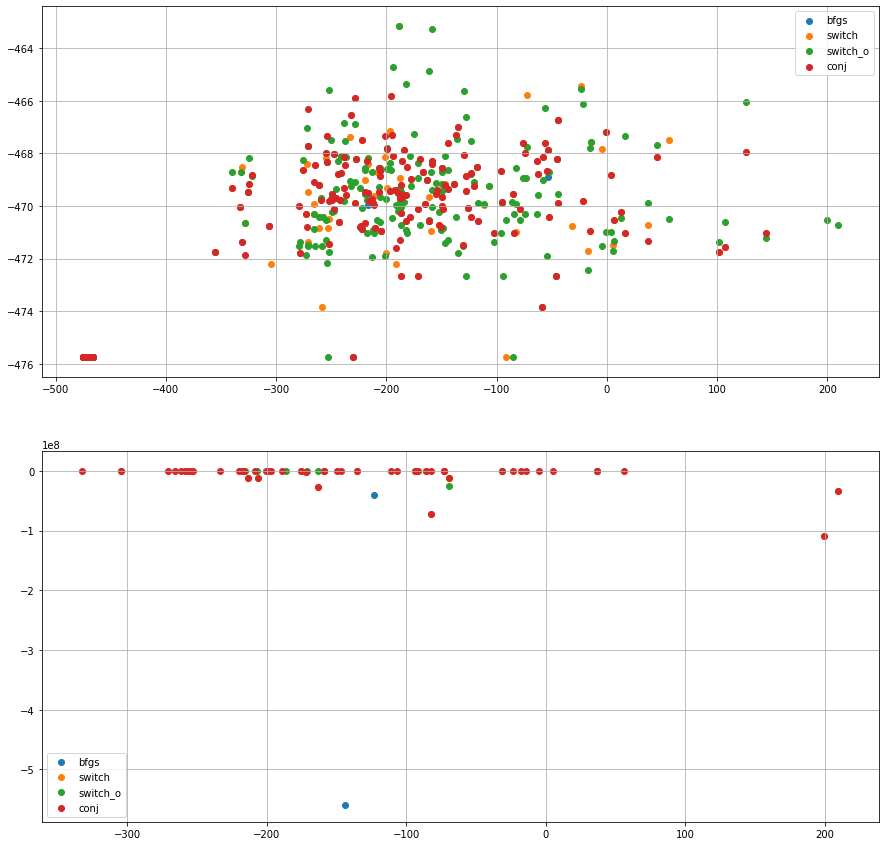

In [58]:
''' Initial vs final energy '''

filename = 'iters'
df = pd.read_csv(FILENAME, skipinitialspace=True)
dfe = pd.read_csv(TESTDIR+'/'+filename+'_energy.csv', skipinitialspace=True)
methods = list(df['method'].unique()) # list of methods

fig, axs = plt.subplots(2, 1, figsize=(15,15))

# Total 
for method in methods: # for each method keep structures from both dfs
    x,y = [],[]
    
    total_m = df.loc[(df['method'] == method)][['structure',
                                                   'opt_succ']].set_index('structure')
    dfe_m = dfe[dfe['method'] == method] # results for this method 
    dfe_m.set_index('structure')
    e_res = dfe_m.join(total_m, on='structure') # join on each struct

    # find successful cases
    e_succ = e_res.loc[e_res['opt_succ'] == True]
    e_succ.drop(['opt_succ'], axis=1)
    for index,row in e_succ.iterrows():
        row = row.dropna() # drop NaN values
        values = row[2:-1]
        x.append(values[0]) # initial energy
        y.append(values[-1]) # final energy

    axs[0].scatter(x, y, label=method)
    axs[0].legend()
    
    x,y = [],[]
    
    # find failed cases
    e_fail = e_res.loc[e_res['opt_succ'] == False]
    e_fail.drop(['opt_succ'], axis=1)
    for index,row in e_fail.iterrows():
        row = row.dropna() # drop NaN values
        values = row[2:-1]
        x.append(values[0]) # initial energy
        y.append(values[-1]) # final energy

    axs[1].scatter(x, y, label=method)
    axs[1].legend()

    
axs[0].grid()
# axs[0].set_xlim(-5, xticks+5)
# axs[0].set_xticks(np.arange(0, xticks+5, 25))
# axs[0].set_title('Iterations of Successful Optimisation')
# axs[0].set_ylabel('Energy (eV)')

axs[1].grid()
# axs[1].set_xlim(-5, xticks+5)
# axs[1].set_xticks(np.arange(0, xticks+5, 25))
# axs[1].set_title('Iterations of Failed Optimisation')
# axs[1].set_ylabel('Energy (eV)')

# plt.savefig(TESTDIR+'/MeanEnergyIter', format=FORMAT)
# plt.show()